In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import json
csv_path = "/home/pranjul/Documents/Hackathon/Hackathon/dataset/output_folder/HG00733_allsvs_10X_phased.csv"
vcf_path = "/home/pranjul/Documents/Hackathon/Hackathon/dataset/output_folder/HG00733_allsvs_10X_phased.vcf"

In [2]:
df = pd.read_csv(csv_path)

In [3]:
df.head()

,chrom,pos,id,svtype,n1,n2,gt,gq,gq_label
0,chr1,181147,.,INS,9,17,./.,11,Moderate
1,chr1,181212,.,DEL,10,18,./.,10,Moderate
2,chr1,181316,.,INS,10,17,./.,9,NaN
3,chr1,181331,.,INS,10,17,./.,9,NaN
4,chr1,610512,.,INS,8,15,./.,10,Moderate


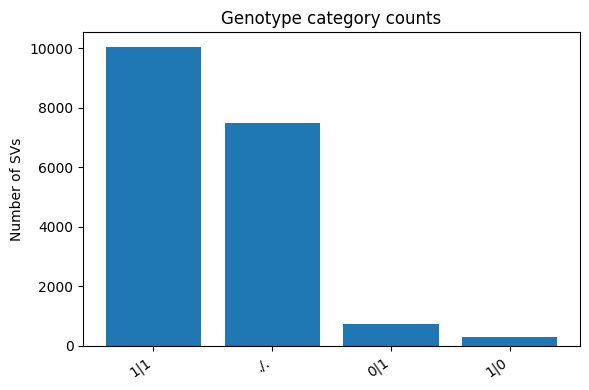

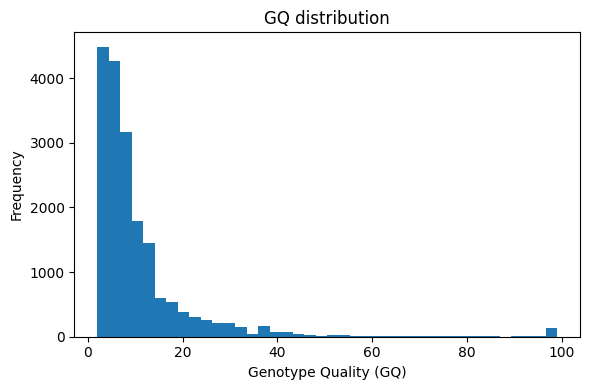

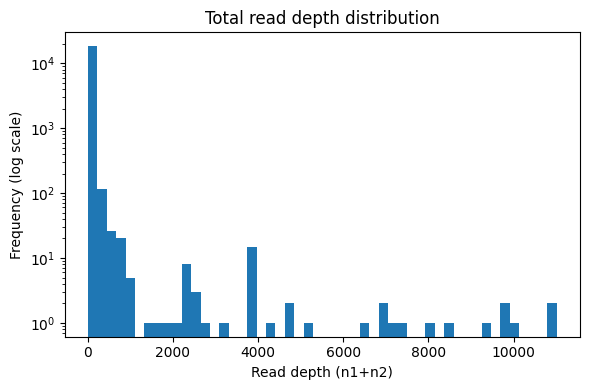

{'genotype_counts': [{'Genotype': '1|1', 'Count': 10028},
  {'Genotype': './.', 'Count': 7472},
  {'Genotype': '0|1', 'Count': 734},
  {'Genotype': '1|0', 'Count': 287}],
 'gq_stats': {'count': 18521.0,
  'mean': 10.651584687651855,
  'std': 12.022626876804713,
  'min': 2.0,
  '25%': 5.0,
  '50%': 7.0,
  '75%': 12.0,
  'max': 99.0},
 'depth_stats': {'count': 18521.0,
  'mean': 38.80773176394363,
  'std': 278.42597617326436,
  'min': 10.0,
  '25%': 17.0,
  '50%': 19.0,
  '75%': 23.0,
  'max': 11008.0},
 'svtype_by_gt': {'./.': {'DEL': 2918, 'DUP': 70, 'INS': 4484},
  '0|1': {'DEL': 275, 'DUP': 2, 'INS': 457},
  '1|0': {'DEL': 125, 'DUP': 0, 'INS': 162},
  '1|1': {'DEL': 3613, 'DUP': 112, 'INS': 6303}}}

In [4]:
# Basic counts
genotype_counts = df['gt'].value_counts().rename_axis('Genotype').reset_index(name='Count')

# SVTYPE counts by genotype
svtype_by_gt = df.pivot_table(index='svtype', columns='gt', values='chrom', aggfunc='count', fill_value=0)

# GQ descriptive stats
gq_stats = df['gq'].describe()

# Depth distribution
df['depth'] = df['n1'] + df['n2']
depth_stats = df['depth'].describe()

summary = {
    "genotype_counts": genotype_counts.to_dict(orient='records'),
    "gq_stats": gq_stats.to_dict(),
    "depth_stats": depth_stats.to_dict(),
    "svtype_by_gt": svtype_by_gt.to_dict()
}

# Plot genotype counts
plt.figure(figsize=(6,4))
plt.bar(genotype_counts['Genotype'], genotype_counts['Count'])
plt.ylabel("Number of SVs")
plt.title("Genotype category counts")
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
# plt.savefig("/mnt/data/genotype_counts.png")
plt.show()

# Plot GQ histogram
plt.figure(figsize=(6,4))
plt.hist(df['gq'], bins=40)
plt.xlabel("Genotype Quality (GQ)")
plt.ylabel("Frequency")
plt.title("GQ distribution")
plt.tight_layout()
# plt.savefig("/mnt/data/gq_hist.png")
plt.show()

# Depth histogram
plt.figure(figsize=(6,4))
plt.hist(df['depth'], bins=50, log=True)
plt.xlabel("Read depth (n1+n2)")
plt.ylabel("Frequency (log scale)")
plt.title("Total read depth distribution")
plt.tight_layout()
# plt.savefig("/mnt/data/depth_hist.png")
plt.show()

summary

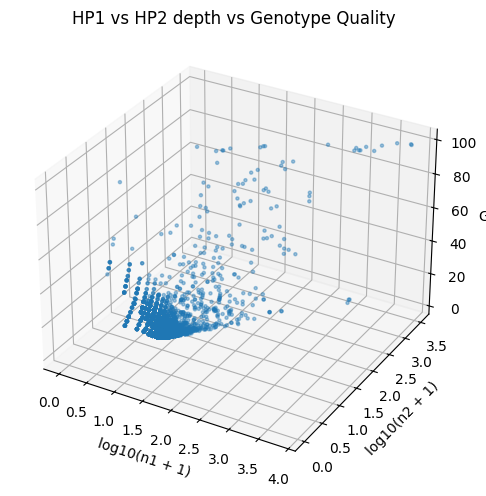

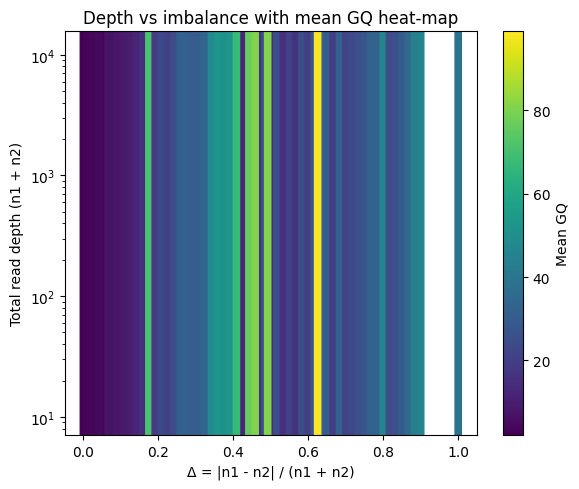

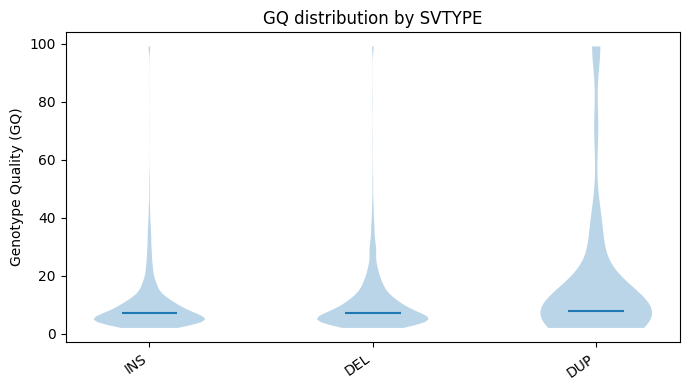

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Convenience columns
df["total"] = df["n1"] + df["n2"]
df["delta"] = (df["n1"] - df["n2"]).abs() / df["total"].replace(0, np.nan)

# ------------------------------------------------------------------
# 1. 3‑D scatter: log10(n1) vs log10(n2) vs GQ
# ------------------------------------------------------------------
fig1 = plt.figure(figsize=(7, 5))
ax1 = fig1.add_subplot(111, projection="3d")

# Sub‑sample for clarity
sample = df.sample(n=min(5000, len(df)), random_state=1)
x = np.log10(sample["n1"] + 1)
y = np.log10(sample["n2"] + 1)
z = sample["gq"]

ax1.scatter(x, y, z, s=5, alpha=0.4)
ax1.set_xlabel("log10(n1 + 1)")
ax1.set_ylabel("log10(n2 + 1)")
ax1.set_title("HP1 vs HP2 depth vs Genotype Quality")
ax1.set_zlabel("GQ")  # For 3D axes, set_zlabel is available; if error persists, use ax1.set_label_text("GQ", axis='z')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2. Heat‑map of imbalance (Δ) vs depth with GQ contours
# ------------------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(6, 5))

# Use hexbin coloured by mean GQ
hb = ax2.hexbin(
    df["delta"],
    df["total"],
    C=df["gq"],
    reduce_C_function=np.mean,
    gridsize=60,
    mincnt=5,
)
ax2.set_xlabel("Δ = |n1 - n2| / (n1 + n2)")
ax2.set_ylabel("Total read depth (n1 + n2)")
ax2.set_yscale("log")
ax2.set_title("Depth vs imbalance with mean GQ heat‑map")
cb = fig2.colorbar(hb, ax=ax2)
cb.set_label("Mean GQ")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3. Violin plots of GQ by SVTYPE
# ------------------------------------------------------------------
fig3, ax3 = plt.subplots(figsize=(7, 4))

# Keep top SVTYPEs by count
top_types = df["svtype"].value_counts().index.tolist()
data = [df[df["svtype"] == t]["gq"] for t in top_types]

parts = ax3.violinplot(data, showmedians=True, showextrema=False)
ax3.set_xticks(np.arange(1, len(top_types) + 1))
ax3.set_xticklabels(top_types, rotation=35, ha="right")
ax3.set_ylabel("Genotype Quality (GQ)")
ax3.set_title("GQ distribution by SVTYPE")

plt.tight_layout()
plt.show()

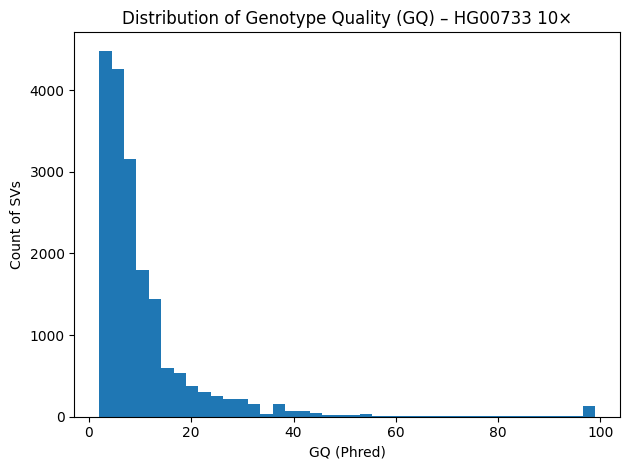

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the phased CSV that is already in the workspace
# csv_path and df are already defined in the notebook

# Basic sanity – show the first rows in an interactive table
df.head()  # Display the first few rows

# Plot: Histogram of GQ (Genotype Quality)
plt.figure()
plt.hist(df["gq"], bins=40)
plt.xlabel("GQ (Phred)")
plt.ylabel("Count of SVs")
plt.title("Distribution of Genotype Quality (GQ) – HG00733 10×")
plt.tight_layout()